In [58]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

# National statistics from NRCan

In [63]:
df_nrcan = pd.read_csv('data/NRCan/Production and shipments of metallic minerals, monthly1, 2 - 16100019-eng/16100019.csv')

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4125653960.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nrcan = pd.read_csv('data/NRCan/Production and shipments of metallic minerals, monthly1, 2 - 16100019-eng/16100019.csv')


In [64]:
df_nrcan

,REF_DATE,GEO,DGUID,Products,Variables,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2020-01,Canada,2016A000011124,Aluminum (tonnes),Quantity produced,Tonnes,287,units,0,v1146004294,1.1.1,254371.0,NaN,NaN,NaN,0
1,2020-01,Canada,2016A000011124,"Aluminum, molten metal (tonnes)",Quantity produced,Tonnes,287,units,0,v1146004554,1.2.1,250396.0,NaN,NaN,NaN,0
2,2020-01,Canada,2016A000011124,"Aluminum, alloys (tonnes)",Quantity produced,Tonnes,287,units,0,v1146004814,1.3.1,3975.0,NaN,NaN,NaN,0
3,2020-01,Canada,2016A000011124,Cobalt recoverable (kilograms),Quantity produced,Kilograms,192,units,0,v1146005045,1.4.1,254663.0,NaN,NaN,NaN,0
4,2020-01,Canada,2016A000011124,Cobalt recoverable (kilograms),Quantity shipped,Kilograms,192,units,0,v1146005061,1.4.2,278622.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131925,2025-02,Nunavut,2016A000262,"Zinc, concentrates (kilograms)",Closing inventories,Kilograms,192,units,0,v1146006222,16.83.3,0.0,NaN,NaN,NaN,0
131926,2025-02,Nunavut,2016A000262,"Zinc, concentrates (dollars)",Value of shipments,Dollars,81,units,0,v1146006238,16.84.4,0.0,NaN,NaN,NaN,0
131927,2025-02,Nunavut,2016A000262,"Zinc, recoverable (kilograms)",Quantity produced,Kilograms,192,units,0,v1146006254,16.85.1,0.0,NaN,NaN,NaN,0
131928,2025-02,Nunavut,2016A000262,"Zinc, recoverable (kilograms)",Quantity shipped,Kilograms,192,units,0,v1146006270,16.85.2,0.0,NaN,NaN,NaN,0


In [65]:
df_nrcan['Products'] = df_nrcan['Products'].replace({
    "Cobalt recoverable (kilograms)": "Cobalt, recoverable (kilograms)"
})
df_nrcan['Products'] = df_nrcan['Products'].replace({
    "Cobalt recoverable (dollars)": "Cobalt, recoverable (dollars)"
})

In [66]:
def compile_metal_data(df, year, geography, variables_to_keep):
    # Ensure REF_DATE is datetime
    df = df.copy()
    df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], format='%Y-%m')

    # Filter for year, geography, and selected variables
    df_filtered = df[
        (df['REF_DATE'].dt.year == year) &
        (df['GEO'] == geography) &
        (df['Variables'].isin(variables_to_keep))
    ]

    # Remove units from product names (anything inside parentheses)
    df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())

    # Split into Commodity and Product_type
    def split_product(product_name):
        if ',' in product_name:
            parts = product_name.split(',', 1)
            commodity = parts[0].strip()
            product_type = parts[1].strip()
        else:
            commodity = product_name.strip()
            product_type = 'Undefined'
        return pd.Series([commodity, product_type])

    df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)

    # Group by Year, Geography, Commodity, Product_type, Variable, Unit
    df_grouped = (
        df_filtered
        .groupby([
            df_filtered['REF_DATE'].dt.year.rename('Year'),
            'GEO',
            'Commodity',
            'Product_type',
            'Variables',
            'UOM'
        ], as_index=False)
        .agg({'VALUE': 'sum'})
        .rename(columns={
            'GEO': 'Geography',
            'Variables': 'Variable',
            'UOM': 'Unit',
            'VALUE': 'Value'
        })
    )
    
    df_grouped = df_grouped[df_grouped['Value'] != 0]  # Remove rows with zero values

    return df_grouped

In [68]:
df_nrcan_prod_2023 = compile_metal_data(df_nrcan, year=2023, geography="Canada", variables_to_keep=["Quantity produced"])
df_nrcan_prod_2023
df_nrcan_prod_2023.to_csv(r'data/NRCan/2023_production.csv', index=False)

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:27: SettingWit

In [75]:
df_nrcan_prod_2023['Product_type'].unique()

array(['Undefined', 'alloys', 'molten metal', 'recoverable', 'refined',
       'concentrates', 'crude and dore'], dtype=object)

In [69]:
df_nrcan_qty_shipments_2023 = compile_metal_data(df_nrcan, year=2023, geography="Canada", variables_to_keep=["Quantity shipped"])
df_nrcan_qty_shipments_2023
df_nrcan_qty_shipments_2023.to_csv(r'data/NRCan/2023_qty_shipments.csv', index=False)

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:27: SettingWit

In [70]:
df_nrcan_value_shipments_2023 = compile_metal_data(df_nrcan, year=2023, geography="Canada", variables_to_keep=["Value of shipments"])
df_nrcan_value_shipments_2023
df_nrcan_value_shipments_2023.to_csv(r'data/NRCan/2023_value_shipments.csv', index=False)

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_20440\4109165775.py:27: SettingWit

In [71]:
def plot_stacked_metal_data(df, variable_to_plot, log_scale=True, title="Metal Data", save_prefix=None):
    """
    General stacked plot for production quantities (Tonnes) or value of shipments (Dollars),
    always keeping Product_type stacking.
    """

    # Define conversion factors to tonnes (only for quantity data)
    unit_conversion = {
        "Tonnes": 1,
        "Kilograms": 1/1000,
        "Grams": 1/1_000_000,
    }
    
    custom_color_dict = {
        'Undefined': '#4c72b0',     # blue
        'refined': '#55a868',       # green
        'concentrates': '#c44e52',  # red
        'recoverable': '#8172b2',   # purple
        'bullion': '#ccb974',       # khaki
        'alloys': '#64b5cd',        # cyan
        'molten metal': '#dd8452',  # orange
    }

    # Filter for selected variable
    df_plot = df[df["Variable"] == variable_to_plot].copy()

    if df_plot.empty:
        print(f"⚠️ No data found for Variable = '{variable_to_plot}'. Skipping plot.")
        return

    unit = df_plot["Unit"].iloc[0]  # get unit now before anything else

    # Harmonize units only if necessary
    if unit not in ["Dollars", "$"]:
        df_plot["Conversion_factor"] = df_plot["Unit"].map(unit_conversion)
        if df_plot["Conversion_factor"].isna().any():
            print("⚠️ Warning: some units could not be converted and were ignored!")
            df_plot = df_plot.dropna(subset=["Conversion_factor"])
        if df_plot.empty:
            print(f"⚠️ No data left after unit conversion. Skipping plot.")
            return
        df_plot["Value_converted"] = df_plot["Value"] * df_plot["Conversion_factor"]
    else:
        # For Dollar data: no conversion
        df_plot["Value_converted"] = df_plot["Value"]

    # Pivot table: rows = Commodity, columns = Product_type, values = Value_converted
    df_pivot = df_plot.pivot_table(
        index="Commodity",
        columns="Product_type",
        values="Value_converted",
        aggfunc="sum",
        fill_value=0
    )

    if df_pivot.empty:
        print("⚠️ Pivot table is empty after filtering. Skipping plot.")
        return

    # Sort commodities by total value
    df_pivot = df_pivot.loc[df_pivot.sum(axis=1).sort_values(ascending=False).index]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 7))

    colors = plt.cm.tab20.colors
    product_types = df_pivot.columns.tolist()
    #color_dict = {ptype: colors[i % len(colors)] for i, ptype in enumerate(product_types)}
    color_dict = {ptype: custom_color_dict.get(ptype, "#b0b0b0") for ptype in product_types}


    bottom = np.zeros(len(df_pivot))
    epsilon = 1e-2  # Small constant to avoid log(0)

    for ptype in product_types:
        values = df_pivot[ptype].values
        ax.bar(
            df_pivot.index,
            values + (epsilon if log_scale else 0),
            bottom=bottom,
            label=ptype,
            color=color_dict[ptype]
        )
        bottom += values

    if log_scale:
        positive_values = df_pivot.values[df_pivot.values > 0]
        if positive_values.size > 0:
            ax.set_yscale('log')
            ymin = positive_values.min()
            ax.set_ylim(bottom=ymin * 0.8)
        else:
            print("⚠️ Warning: No positive values found. Skipping log scale.")

    # Set y-axis label based on unit
    if unit.lower() in ["dollars", "$"]:
        ylabel = "Value of Shipments (Dollars)"
    else:
        ylabel = "Production (Tonnes)"

    ax.set_ylabel(ylabel + (" (log scale)" if log_scale else ""), fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    plt.xticks(rotation=60, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(fontsize=10, title_fontsize=10, loc="upper right")

    plt.tight_layout()

    if save_prefix:
        plt.savefig(f"{save_prefix}.pdf", dpi=600, bbox_inches='tight', transparent=True)
        plt.savefig(f"{save_prefix}.png", dpi=600, bbox_inches='tight', transparent=True)

    plt.show()


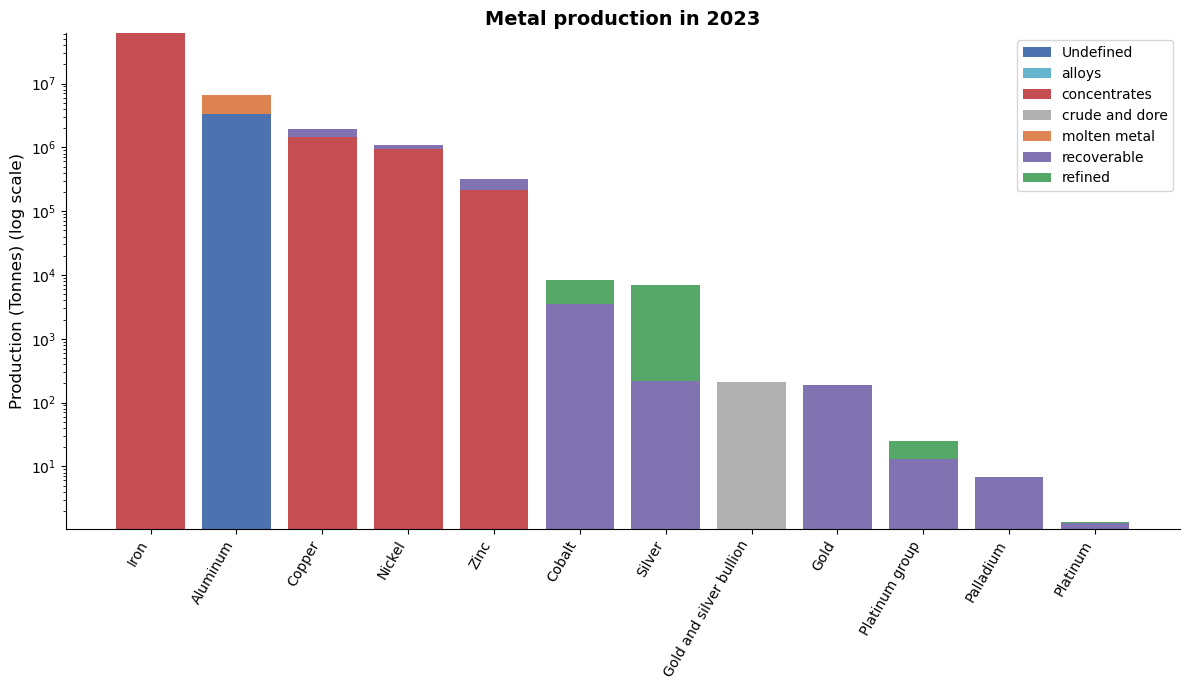

In [72]:
plot_stacked_metal_data(df_nrcan_prod_2023, variable_to_plot="Quantity produced", log_scale=True, title="Metal production in 2023", save_prefix="results/production_2023_nrcan")

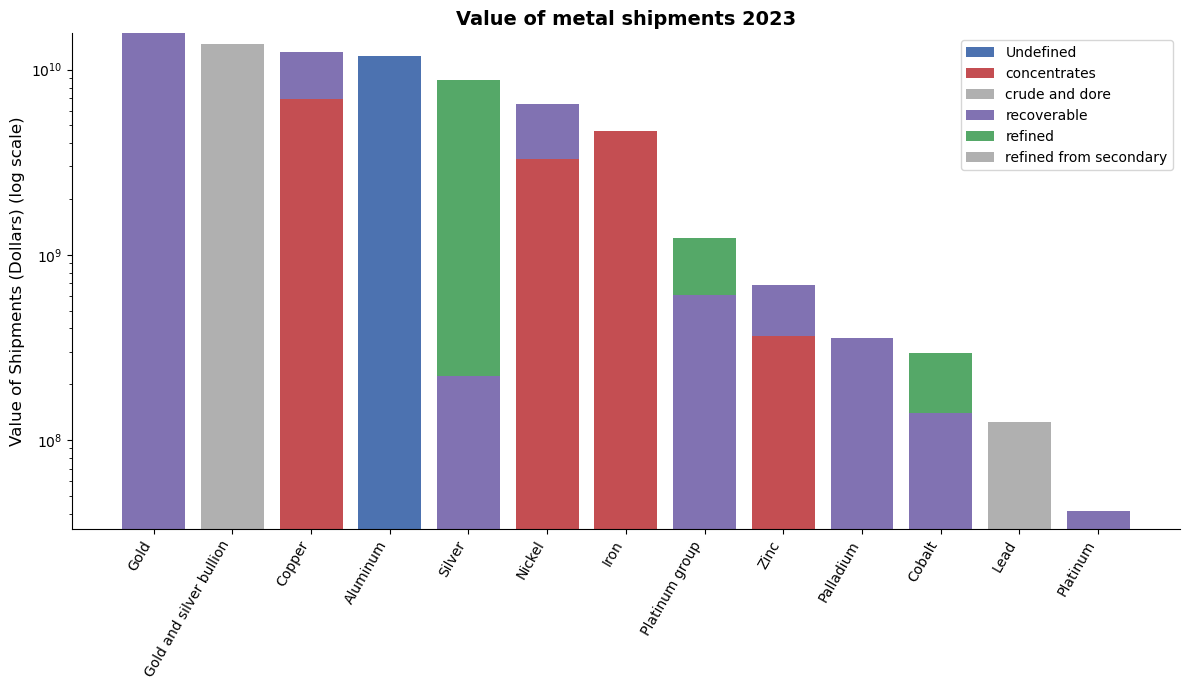

In [73]:
plot_stacked_metal_data(df_nrcan_value_shipments_2023, variable_to_plot="Value of shipments", log_scale=True, title="Value of metal shipments 2023", save_prefix="results/value_shipments_2023_nrcan")

# Production data from MetalliCan

In [51]:
df_metallican_prod = pd.read_excel(r'data/Tables/extracted_data.xlsx', sheet_name='Production')

In [54]:
df_metallican_prod['material_type'].unique()

array(['Ore processed', 'Intermediate metal', 'Concentrate', 'Ore mined',
       'Ore grade', 'Mill grade', 'Mill recovery rate',
       'Intermediate metal?', 'Aluminum production',
       'Concentrate & pellets', 'Flat', 'Long/wire rod, bars, slabs',
       'Mining production', nan, 'Intermediate metal ',
       'Waste rock mined', 'Coal output', 'Waste mined',
       'Carats recovered', 'Tonnes mined', 'Head grade', 'Recovery rate',
       'Concentrate produced', 'Ore mined and hauled',
       'Carats recovered|Canada', 'Carats recovered|World', 'Ore milled',
       'Material mined', 'EAF production', 'Nominal crude steel capacity',
       'Refined metal', '?', 'Refinery production', 'Ore grade?',
       'Head grade?', 'Concentrate grade',
       'Contained metal in concentrate',
       'Total contained metal in concentrate and doré produced',
       'Strip ratio', 'Grade', 'Ore mined?', 'Mill ore grade',
       'Ore mined|OP ore', 'Ore mined|OP waste', 'Ore mined|Underground',
    

In [ ]:
def filter_for_validation(df):
    """Filter the production dataset for technical validation."""
    valid_material_types = [
        "Intermediate metal",
        "Concentrate produced",
        "Metal produced (refined)",
        "Alloys produced",
        "Molten metal produced"
    ]
    valid_units = ["t", "tonnes", "kt", "kg", "oz", "koz"]

    df_filtered = df[
        (df['material_type'].isin(valid_material_types)) &
        (df['unit'].str.lower().isin([u.lower() for u in valid_units]))
    ].copy()

    return df_filtered

def aggregate_by_commodity_and_region(df_filtered):
    """Aggregate filtered production by commodity and region."""
    df_filtered['region'] = df_filtered['id'].str.slice(0, 2)

    df_grouped = (
        df_filtered
        .groupby(['region', 'commodity'], as_index=False)
        .agg({'quantity': 'sum'})
    )

    return df_grouped